## Forward and inverse models for Experiment 1

In [2]:
import h5py
import numpy as np

with h5py.File('../../data/kinematics/kuka_rnd_500k_n10_v2_f10.h5', 'r') as hf:
    kuka_fwd = hf['kuka_fwd'][()]
    kuka_inv = hf['kuka_inv'][()]

n_joints = 7

X_fwd, y_fwd = np.hsplit(kuka_fwd, [n_joints + 3 + n_joints])
y_fwd_joints, y_fwd_eff = np.hsplit(y_fwd, [n_joints])

X_inv, y_inv = np.hsplit(kuka_inv, [2 * (n_joints + 3)])

In [ ]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Sequential, Model

In [4]:
inp = Input(shape=(n_joints + 3 + n_joints,))
h = Dense(30, activation='tanh')(inp)

hj = Dense(20, activation='tanh')(h)
joints = Dense(n_joints, activation='linear', name='joints_out')(hj)

he = Dense(20, activation='tanh')(h)
eff = Dense(3, activation='linear', name='eff_out')(he)

fwd_model = Model(
    inputs=inp,
    outputs=[joints, eff],
    name='fwd_model'
)

fwd_model.summary()

Model: "fwd_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 17)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 30)                   540       ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 20)                   620       ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 20)                   620       ['dense[0][0]']               
                                                                                          

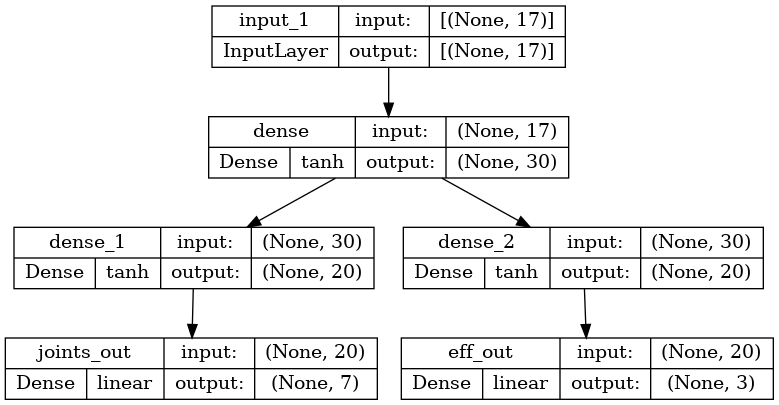

In [5]:
from tensorflow.keras.utils import plot_model

plot_model(
    fwd_model,
    to_file='../../plots/kuka/kinematics/kuka_fwd_model.png',
    show_shapes=True,
    show_layer_names=True,
    show_layer_activations=True
)

In [7]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.callbacks import TensorBoard

fwd_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={
        'joints_out': MeanSquaredError(),
        'eff_out': MeanSquaredError()
    },
    metrics={
        'joints_out': [MeanAbsoluteError()],
        'eff_out': [MeanAbsoluteError()]
    }
)

fwd_history = fwd_model.fit(
    x=X_fwd,
    y={
        'joints_out': y_fwd_joints,
        'eff_out': y_fwd_eff
    },
    batch_size=2048,
    epochs=60,
    callbacks=[TensorBoard(log_dir='../../logs/kuka_kinematics_fwd_60ep', write_graph=False)],
    validation_split=0.2,
    shuffle=True
)

Epoch 1/60
196/196 [==============================] - 5s 13ms/step - loss: 0.1696 - joints_out_loss: 0.0759 - eff_out_loss: 0.0938 - joints_out_mean_absolute_error: 0.1882 - eff_out_mean_absolute_error: 0.1600 - val_loss: 0.0145 - val_joints_out_loss: 0.0104 - val_eff_out_loss: 0.0041 - val_joints_out_mean_absolute_error: 0.0766 - val_eff_out_mean_absolute_error: 0.0473
Epoch 2/60
196/196 [==============================] - 3s 13ms/step - loss: 0.0071 - joints_out_loss: 0.0042 - eff_out_loss: 0.0029 - joints_out_mean_absolute_error: 0.0463 - eff_out_mean_absolute_error: 0.0391 - val_loss: 0.0038 - val_joints_out_loss: 0.0017 - val_eff_out_loss: 0.0021 - val_joints_out_mean_absolute_error: 0.0298 - val_eff_out_mean_absolute_error: 0.0337
Epoch 3/60
196/196 [==============================] - 2s 10ms/step - loss: 0.0031 - joints_out_loss: 0.0012 - eff_out_loss: 0.0018 - joints_out_mean_absolute_error: 0.0248 - eff_out_mean_absolute_error: 0.0315 - val_loss: 0.0025 - val_joints_out_loss: 9.

In [11]:
fwd_model.save('../../models/kinematics/kuka_fwd.keras')

In [10]:
X_inv_joints_0, X_inv_eff_0, X_inv_joints_1, X_inv_eff_1 = np.hsplit(X_inv, [7, 10, 17])

In [5]:
X_inv_joints_0[0], X_inv_eff_0[0], X_inv_joints_1[0], X_inv_eff_1[0]

(array([ 0.47814612,  1.01088088,  0.14595406, -0.1642068 ,  0.13321023,
         1.48260318,  0.04166609,  0.        ]),
 array([-0.418692  ,  0.60704034,  0.45248409]),
 array([ 4.40384184e-01,  9.77264227e-01,  1.87687338e-01, -2.05848840e-01,
         9.15602623e-02,  1.44095981e+00,  5.41884522e-05,  0.00000000e+00]),
 array([-0.3950734 ,  0.60944484,  0.45346423]))

In [12]:
X_inv_mod = np.hstack((X_inv_joints_0, X_inv_eff_0, X_inv_eff_1))

In [14]:
inv_model = Sequential(
    layers=[
        Input(shape=(n_joints + 3 + 3,)),
        Dense(40, activation='tanh'),
        Dense(60, activation='tanh'),
        Dense(60, activation='tanh'),
        Dense(40, activation='tanh'),
        Dense(n_joints, activation='linear')
    ],
    name='inv_model'
)

inv_model.summary()

Model: "inv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 40)                560       
                                                                 
 dense_4 (Dense)             (None, 60)                2460      
                                                                 
 dense_5 (Dense)             (None, 60)                3660      
                                                                 
 dense_6 (Dense)             (None, 40)                2440      
                                                                 
 dense_7 (Dense)             (None, 7)                 287       
                                                                 
Total params: 9407 (36.75 KB)
Trainable params: 9407 (36.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.callbacks import TensorBoard

inv_model.compile(
    optimizer=AdamW(learning_rate=0.001, weight_decay=0.004),
    loss=MeanSquaredError(),
    metrics=[MeanAbsoluteError()]
)

inv_history = inv_model.fit(
    X_inv_mod, y_inv,
    batch_size=2048,
    epochs=1000,
    callbacks=[
        TensorBoard(write_graph=False)
    ],
    validation_split=0.2,
    shuffle=True
)

In [30]:
fwd_model.save('models/kinematics/panda_fwd.keras')
inv_model.save('models/kinematics/panda_inv.keras')